In [12]:
import numpy as np
import pandas as pd
import pickle
import random
from datetime import datetime

from elasticsearch import Elasticsearch, helpers
import eland as ed

import umap

from timeit import default_timer as timer

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from matplotlib.lines import Line2D

In [2]:
def save_data(data, filepath):
    """Save data to disk using pickle."""

    with open(filepath, 'wb') as handle:
        pickle.dump(data, handle)



def load_data(filepath):
    """Load and return the given pickle file."""

    with open(filepath, 'rb') as handle:
        return pickle.load(handle) 

In [3]:
def query_es_db(es, dataset_hash):
    """Query records from ES DB that does not have relevance value.
        Return them in a Pandas DataFrame."""

    df = ed.DataFrame(es_client=es, es_index_pattern=dataset_hash, columns=['oldhash', 
                                                                            'is_relevant', 
                                                                            'predicted_benefits'])  
    return df[(df['is_relevant'] == True) and (df['predicted_benefits'] != 'N/A')].to_pandas()

In [4]:
#elasticPort = ...
#elasticScheme = ...
#elasticTimeout = ...
#elasticHost = ...
#elasticUsername = ...
#elasticPassword = ...

es = Elasticsearch(
    [elasticHost],
    http_auth=(elasticUsername, elasticPassword),
    scheme=elasticScheme,
    port=elasticPort,
    request_timeout=elasticTimeout,
)

In [5]:
%%time
df = query_es_db(es, 'b03cfa2ed488653e0ae8bd6d1d7f720686f6241a')
df.reset_index(inplace=True)
df.set_index('oldhash', inplace=True)

CPU times: user 12.7 s, sys: 11.2 s, total: 23.9 s
Wall time: 6min 36s


In [6]:
representative_uids = load_data('../../../../ncs/PaperMaterials/Data/representative_docs_uids_10.pickle')

In [7]:
embedding_keys = load_data('../../../../ncs/PaperMaterials/Data/embedding_keys.pickle')

In [8]:
representative_embeddings_gt = list()
representative_embeddings = list()
oot = 0
ind = 0
start_time = timer()

for k,v in representative_uids.items():
    
    ind += 1
    
    if ind % 100 == 0: print(ind, timer()-start_time)
    
    for uid in v:
        try:
            new_uid = df.loc[uid, 'index']
        except:
            oot += 1
        if new_uid in embedding_keys:
            #representative_embeddings.append(embeddings[new_uid])
            representative_embeddings_gt.append((k, new_uid))

100 117.66482874999997
200 434.684423209
300 837.754132584


In [9]:
X = load_data('../../../../ncs/PaperMaterials/Data/X_tsne_umap.pickle')

In [10]:
topic_gt = pd.read_excel('../../../../ncs/PaperMaterials/Data/topics-pathways-benefits-1-18-23__.xlsx', 
                         keep_default_na=False, 
                         index_col=0)
topic_gt.set_index('TopicNumber', inplace=True)
colors = list()
forest_color = '#617143'
grassland_color = '#E6B325'
wetland_color = '#146C94'
agriculture_color = '#B99B6B'
for re in representative_embeddings_gt:
    anthrome = topic_gt.loc[re[0], 'Anthrome']
    if anthrome == 'Agriculture':
        colors.append(agriculture_color)
    elif anthrome == 'Wetland':
        colors.append(wetland_color)
    elif anthrome == 'Grassland':
        colors.append(grassland_color)
    else:
        colors.append(forest_color)

/Users/pappd/miniforge3/envs/ncs/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


---
---
---

In [13]:
print("Start Time =", datetime.now().strftime("%H:%M:%S"))
X_tsne = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=100).fit_transform(X)
print("Finish Time =", datetime.now().strftime("%H:%M:%S"))

Start Time = 16:27:19
Finish Time = 16:27:36


In [14]:
font_family_type = 'arial'
font_size = 20
font_size_legend = 16

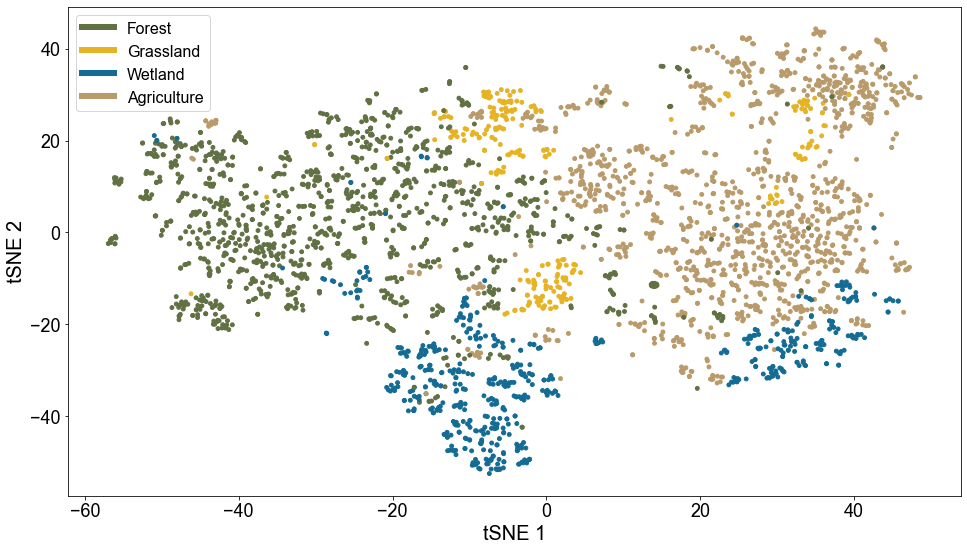

In [15]:
plt.figure(figsize=(16,9))
plt.scatter(X_tsne[:, 0],X_tsne[:, 1],s=15,c=colors)
plt.xticks(fontsize=font_size-2, fontname = font_family_type)
plt.yticks(fontsize=font_size-2, fontname = font_family_type)
custom_lines = [Line2D([0], [0], color=forest_color, lw=6),
                Line2D([0], [0], color=grassland_color, lw=6),
                Line2D([0], [0], color=wetland_color, lw=6), 
                Line2D([0], [0], color=agriculture_color, lw=6)]
plt.legend(custom_lines, 
           ['Forest', 'Grassland', 'Wetland', 'Agriculture'], 
           prop={'family':font_family_type, 'size':font_size_legend})
plt.xlabel("tSNE 1", fontdict = {'family':font_family_type,'color':'black','size':font_size})
plt.ylabel("tSNE 2", fontdict = {'family':font_family_type,'color':'black','size':font_size})
plt.savefig('t_SNE.png')
plt.savefig('t_SNE.pdf')

In [16]:
print("Start Time =", datetime.now().strftime("%H:%M:%S"))

umap_model_2D = umap.UMAP(n_neighbors=100, 
                          n_components=2, 
                          min_dist=0.0,  
                          metric='cosine',
                          random_state=42)
umap_data_2D = umap_model_2D.fit_transform(X)

print("Finish Time =", datetime.now().strftime("%H:%M:%S"))

Start Time = 16:27:37


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Finish Time = 16:27:58


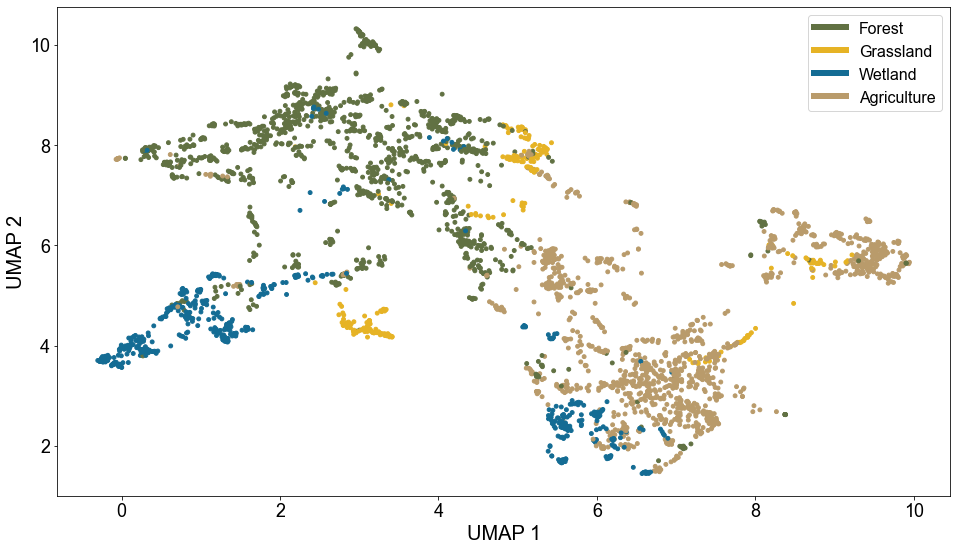

In [17]:
point_size = 50.0 / np.sqrt(X.shape[0])
    
result = pd.DataFrame(umap_data_2D, columns=['x', 'y'])
result['color'] = colors
result['size'] = 0.25
fig, ax = plt.subplots(figsize=(16, 9))
plt.scatter(result.x, result.y, s=15, alpha=1, c=colors, cmap='jet')
plt.xticks(fontsize=font_size-2, fontname = font_family_type)
plt.yticks(fontsize=font_size-2, fontname = font_family_type)
custom_lines = [Line2D([0], [0], color=forest_color, lw=6),
                Line2D([0], [0], color=grassland_color, lw=6),
                Line2D([0], [0], color=wetland_color, lw=6), 
                Line2D([0], [0], color=agriculture_color, lw=6)]
plt.legend(custom_lines, 
           ['Forest', 'Grassland', 'Wetland', 'Agriculture'], 
           prop={'family':font_family_type, 'size':font_size_legend})
plt.xlabel("UMAP 1", fontdict = {'family':font_family_type,'color':'black','size':font_size})
plt.ylabel("UMAP 2", fontdict = {'family':font_family_type,'color':'black','size':font_size})
plt.savefig('UMAP.png')
plt.savefig('UMAP.pdf')
plt.show()